In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, ConfusionMatrixDisplay, confusion_matrix
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

In [2]:
import pandas as pd
print(pd.__version__)

1.0.5


In [2]:
import seaborn as sns

Informacion de las columnas
- item_id
- description: Descripcion del shipping (por ejemplo, free shipping, letter, priority mail, etc)
- est_delivery: Tiempo estimado de entrega (generalmente en días)
- price: Precio de la opción de envio [BTC]
- timestamp: Fecha y hora en la que se scrapeo

In [3]:
shipping_skilroad = pd.read_csv('csv/silkroad_shippings.csv')
shipping_skilroad.head()

,item_id,description,est_delivery,price,timestamp
0,jj-luna-privacy-ebooks,ebook link,1 day,0.000000,2014-02-23T05:39:22
1,the-morality-of-capitalism,letter,4 days,0.001722,2014-02-23T05:39:29
2,survive,small book (domestic),4 days,0.017217,2014-02-23T05:39:33
3,a-non-religious-new-testament,media mail parcel (domestic),4 days,0.006870,2014-02-23T05:39:37
4,mindless-slogans-101-cheap-substitutes-for-act...,ebook link,1 day,0.000000,2014-02-23T05:39:41


In [4]:
bitcoin = pd.read_csv('csv/bitcoins.csv')
bitcoin

,Date,Price,Open,High,Low,Vol.,Change %
0,"Feb 23, 2014",272.6,210.9,297.8,217.7,7.08K,29.29%
1,"Feb 24, 2014",153.6,272.6,252.1,129.0,12.05K,-43.65%
2,"Feb 25, 2014",198.8,153.6,226.6,163.9,7.70K,29.36%
3,"Feb 26, 2014",430.6,198.8,442.1,372.3,2.33K,116.67%
4,"Feb 27, 2014",432.3,430.6,438.3,424.2,1.05K,0.39%
...,...,...,...,...,...,...,...
331,"Jan 20, 2015",183.9,188.1,188.2,179.0,4.89K,-2.24%
332,"Jan 21, 2015",196.9,183.9,199.0,183.3,5.32K,7.05%
333,"Jan 22, 2015",204.6,196.9,207.8,194.7,6.33K,3.92%
334,"Jan 23, 2015",207.8,204.6,209.7,198.2,4.28K,1.56%


In [5]:
shipping_skilroad.rename(columns={'est_delivery':'delivery_days'},inplace=True)
shipping_skilroad.head()

,item_id,description,delivery_days,price,timestamp
0,jj-luna-privacy-ebooks,ebook link,1 day,0.000000,2014-02-23T05:39:22
1,the-morality-of-capitalism,letter,4 days,0.001722,2014-02-23T05:39:29
2,survive,small book (domestic),4 days,0.017217,2014-02-23T05:39:33
3,a-non-religious-new-testament,media mail parcel (domestic),4 days,0.006870,2014-02-23T05:39:37
4,mindless-slogans-101-cheap-substitutes-for-act...,ebook link,1 day,0.000000,2014-02-23T05:39:41


In [6]:
shipping_skilroad['timestamp'] = pd.to_datetime(shipping_skilroad['timestamp'])
bitcoin['Date'] = pd.to_datetime(bitcoin['Date'])

In [7]:
def make_numeric(x):
    num = ""
    for letter in x:
        if letter.isnumeric():
            num +=letter
    return num

In [8]:
shipping_skilroad['delivery_days'] = shipping_skilroad['delivery_days'].map(make_numeric)
shipping_skilroad['delivery_days']

0         1
1         4
2         4
3         4
4         1
         ..
560453    3
560454    3
560455    1
560456    3
560457    7
Name: delivery_days, Length: 560458, dtype: object

In [9]:
shipping_skilroad['date'] =shipping_skilroad['timestamp'].dt.date

In [10]:
bitcoin.rename(columns={'Date':'date'},inplace=True)
bitcoin

,date,Price,Open,High,Low,Vol.,Change %
0,2014-02-23,272.6,210.9,297.8,217.7,7.08K,29.29%
1,2014-02-24,153.6,272.6,252.1,129.0,12.05K,-43.65%
2,2014-02-25,198.8,153.6,226.6,163.9,7.70K,29.36%
3,2014-02-26,430.6,198.8,442.1,372.3,2.33K,116.67%
4,2014-02-27,432.3,430.6,438.3,424.2,1.05K,0.39%
...,...,...,...,...,...,...,...
331,2015-01-20,183.9,188.1,188.2,179.0,4.89K,-2.24%
332,2015-01-21,196.9,183.9,199.0,183.3,5.32K,7.05%
333,2015-01-22,204.6,196.9,207.8,194.7,6.33K,3.92%
334,2015-01-23,207.8,204.6,209.7,198.2,4.28K,1.56%


In [11]:
bitcoin.date = bitcoin.date.astype('datetime64[ns]')
shipping_skilroad.date = shipping_skilroad.date.astype('datetime64[ns]')

In [12]:
merged = shipping_skilroad.merge(bitcoin,on='date',how='left')
shipping = merged[['item_id','description','delivery_days','price','Price','date']]

In [13]:
shipping['EU_price'] = shipping['Price'] * shipping['price']

<ipython-input-13-7431d3a2679f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shipping['EU_price'] = shipping['Price'] * shipping['price']


In [14]:
# Filtro, aquellos shippings que poseen precios irreales, dejando como maximo 5000
real_price_shipping = shipping[(shipping['EU_price'] >= 0) & (shipping['EU_price'] <= 5000)]
real_price_shipping

,item_id,description,delivery_days,price,Price,date,EU_price
0,jj-luna-privacy-ebooks,ebook link,1,0.000000,272.6,2014-02-23,0.000000
1,the-morality-of-capitalism,letter,4,0.001722,272.6,2014-02-23,0.469417
2,survive,small book (domestic),4,0.017217,272.6,2014-02-23,4.693354
3,a-non-religious-new-testament,media mail parcel (domestic),4,0.006870,272.6,2014-02-23,1.872762
4,mindless-slogans-101-cheap-substitutes-for-act...,ebook link,1,0.000000,272.6,2014-02-23,0.000000
...,...,...,...,...,...,...,...
560453,us-only-250x-140mg-pure-84-mdma-capsules-aidoneus,Priority Mail,3,0.018512,220.4,2015-01-24,4.080045
560454,us-only-250x-140mg-pure-84-mdma-capsules,Priority Mail,3,0.018363,220.4,2015-01-24,4.047205
560455,us-only-10x-140mg-pure-84-mdma-capsules-aidoneus,Priority Mail Express,1,0.064269,220.4,2015-01-24,14.164888
560456,us-only-10x-140mg-pure-84-mdma-capsules-aidoneus,Priority Mail,3,0.018363,220.4,2015-01-24,4.047205


In [15]:
# Limpio la memoria
del shipping

In [16]:
shippin_no_id = real_price_shipping[['description','delivery_days','EU_price','date']]
shippin_no_id

,description,delivery_days,EU_price,date
0,ebook link,1,0.000000,2014-02-23
1,letter,4,0.469417,2014-02-23
2,small book (domestic),4,4.693354,2014-02-23
3,media mail parcel (domestic),4,1.872762,2014-02-23
4,ebook link,1,0.000000,2014-02-23
...,...,...,...,...
560453,Priority Mail,3,4.080045,2015-01-24
560454,Priority Mail,3,4.047205,2015-01-24
560455,Priority Mail Express,1,14.164888,2015-01-24
560456,Priority Mail,3,4.047205,2015-01-24


In [17]:
def a(x):
    if x == '':
        return 0
    else:
        return x

In [18]:
shippin_no_id['delivery_days'] = shippin_no_id['delivery_days'].map(a)
shippin_no_id.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 560260 entries, 0 to 560457
Data columns (total 4 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   description    559466 non-null  object        
 1   delivery_days  560260 non-null  object        
 2   EU_price       560260 non-null  float64       
 3   date           560260 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 21.4+ MB


<ipython-input-18-4345f1a67300>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shippin_no_id['delivery_days'] = shippin_no_id['delivery_days'].map(a)


In [19]:
shippin_no_id['delivery_days'].fillna(0,inplace=True)

C:\Users\alejo\anaconda3\lib\site-packages\pandas\core\generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [20]:
shippin_no_id['delivery_days'].value_counts()

3     75154
1     71906
5     71198
7     60071
2     59047
4     42912
10    40594
14    36559
8     18854
15    15388
6     14052
12    11708
9     10015
20     8205
21     5599
18     4543
30     3206
13     3114
11     2747
0      1773
16     1728
17      745
19      512
25      392
22      107
23       93
28       30
26        8
Name: delivery_days, dtype: int64

In [21]:
shippin_no_id['delivery_days'] = shippin_no_id['delivery_days'].astype(int)

<ipython-input-21-12b337f2117f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shippin_no_id['delivery_days'] = shippin_no_id['delivery_days'].astype(int)


In [22]:
# Para la descripcion, quizas sea conveniente usar un hot-encoding, me fijo cuantas valores unicos posee description
shippin_no_id['description'].nunique()

4040

In [23]:
shippin_no_id['description'].fillna('unknown',inplace=True)

In [ ]:
# Como hay 4040 muestras unicas, un one-hot-encoding será problematico.
# Por lo que usaré un label encoding para description
shippin_no_id.info()

## Modelado

Antes de armar los encondigs, separo mi dataset en validation y training.

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.metrics import mean_absolute_error

In [25]:
y = shippin_no_id.EU_price
X = shippin_no_id.drop(['EU_price'],axis=1)

In [26]:
# Para lograr un mejor encoding, separare las fechas en columnas distintas
X['year'] = X['date'].dt.year
X['month']= X['date'].dt.month
X['day']= X['date'].dt.day
X

,description,delivery_days,date,year,month,day
0,ebook link,1,2014-02-23,2014,2,23
1,letter,4,2014-02-23,2014,2,23
2,small book (domestic),4,2014-02-23,2014,2,23
3,media mail parcel (domestic),4,2014-02-23,2014,2,23
4,ebook link,1,2014-02-23,2014,2,23
...,...,...,...,...,...,...
560453,Priority Mail,3,2015-01-24,2015,1,24
560454,Priority Mail,3,2015-01-24,2015,1,24
560455,Priority Mail Express,1,2015-01-24,2015,1,24
560456,Priority Mail,3,2015-01-24,2015,1,24


In [27]:
del X['date']

In [28]:
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.2, random_state=42)

In [29]:
X_train

,description,delivery_days,year,month,day
428450,UK,2,2014,10,10
378537,EU 1st Class,5,2014,9,26
6593,Express (1-2 Days),1,2014,6,10
429028,Priority USPS,5,2014,10,10
134691,UK,4,2014,6,10
...,...,...,...,...,...
110334,"EXPRESS- 1-3 days, Aus Post, Tracking,",1,2014,6,10
259337,First Class UK,2,2014,8,15
366014,First Class Worldwide (Awesome stealth),11,2014,9,19
131998,Standard shipping,2,2014,6,10


In [30]:
# Hago un label enconding para description
ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value',unknown_value=-1)
X_train['description'] = ordinal_encoder.fit_transform(X_train['description'].astype(str).values.reshape(-1,1))
X_train

,description,delivery_days,year,month,day
428450,2970.0,2,2014,10,10
378537,794.0,5,2014,9,26
6593,995.0,1,2014,6,10
429028,2377.0,5,2014,10,10
134691,2970.0,4,2014,6,10
...,...,...,...,...,...
110334,900.0,1,2014,6,10
259337,1364.0,2,2014,8,15
366014,1369.0,11,2014,9,19
131998,2812.0,2,2014,6,10


In [31]:
# Se instancia el modelo con 1000 arboles
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)

# Se entrena el modelo
rf.fit(X_train, y_train);

In [32]:
# Hago los encodings del validation
X_validation['description'] = ordinal_encoder.transform(X_validation['description'].astype(str).values.reshape(-1,1))
X_validation

,description,delivery_days,year,month,day
237213,878.0,4,2014,8,6
466449,2812.0,4,2014,10,19
412003,3051.0,5,2014,10,6
11583,3170.0,3,2014,6,10
145560,1889.0,5,2014,6,10
...,...,...,...,...,...
365907,3027.0,7,2014,9,19
35617,1361.0,3,2014,6,10
181028,3433.0,14,2014,6,18
112997,1963.0,8,2014,6,10


In [33]:
predictions = rf.predict(X_validation)

In [34]:
predictions = pd.Series(predictions)
predictions

0         15.579036
1          7.041744
2          4.390956
3         10.670147
4          4.896324
            ...    
112047    20.339875
112048     3.973280
112049     6.261879
112050    10.422189
112051     3.764652
Length: 112052, dtype: float64

In [35]:
y_validation = y_validation.reset_index()

In [36]:
del y_validation['index']

In [37]:
y_validation.loc[y_validation['EU_price'] == 'NaN']

C:\Users\alejo\anaconda3\lib\site-packages\pandas\core\ops\array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


,EU_price


In [38]:
mean_absolute_error(predictions,y_validation['EU_price'])

1.3899290378181832

In [40]:
predictions

0         15.579036
1          7.041744
2          4.390956
3         10.670147
4          4.896324
            ...    
112047    20.339875
112048     3.973280
112049     6.261879
112050    10.422189
112051     3.764652
Length: 112052, dtype: float64

In [41]:
result = pd.concat([y_validation,predictions],axis=1)
result

,EU_price,0
0,15.578662,15.579036
1,7.072845,7.041744
2,4.390956,4.390956
3,8.133858,10.670147
4,7.526925,4.896324
...,...,...
112047,20.181408,20.339875
112048,3.353902,3.973280
112049,12.650684,6.261879
112050,12.953002,10.422189


In [42]:
result.rename(columns={0:'EU_price_prediction'},inplace=True)
result

,EU_price,EU_price_prediction
0,15.578662,15.579036
1,7.072845,7.041744
2,4.390956,4.390956
3,8.133858,10.670147
4,7.526925,4.896324
...,...,...
112047,20.181408,20.339875
112048,3.353902,3.973280
112049,12.650684,6.261879
112050,12.953002,10.422189


In [43]:
result['relative_error'] = abs((result['EU_price'] -result['EU_price_prediction'])/result['EU_price'])
result

,EU_price,EU_price_prediction,relative_error
0,15.578662,15.579036,2.403334e-05
1,7.072845,7.041744,4.397247e-03
2,4.390956,4.390956,1.962063e-14
3,8.133858,10.670147,3.118187e-01
4,7.526925,4.896324,3.494922e-01
...,...,...,...
112047,20.181408,20.339875,7.852114e-03
112048,3.353902,3.973280,1.846736e-01
112049,12.650684,6.261879,5.050166e-01
112050,12.953002,10.422189,1.953843e-01


Text(0, 0.5, 'prediccion')

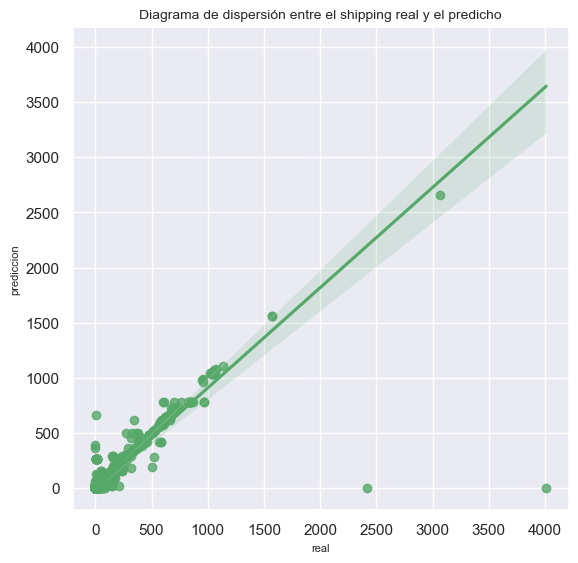

In [44]:
sns.set(rc={"figure.dpi":100,'figure.figsize':(6.4,6.4)})
ax= sns.regplot(data=result, x="EU_price", y="EU_price_prediction",color="g")
ax.set_title("Diagrama de dispersión entre el shipping real y el predicho",fontsize=10)
ax.set_xlabel("real",fontsize=8)
ax.set_ylabel("prediccion",fontsize=8)